In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
import winsound


random_seed = 1337
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
# torch.use_deterministic_algorithms(False)
train_ratio = 0.80 # 80% for training, 20% for validation

BATCH_SIZE= 64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2) 

print(NUM_WORKERS)
print(AVAIL_GPUS)

4
0


In [ ]:
json_dir = '../learning-data/'

all_segments = []
all_grass_positions = []
all_starting_points = []

# Helper function to compute length and angle
def compute_length_and_angle(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return length, angle

failed_file = None
# Iterate through JSON files
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        # delete failed file if it exists
        if failed_file is not None:
            os.remove(failed_file)
            failed_file = None
        with open(os.path.join(json_dir, filename), 'r') as f:
            try:
                ground_data = json.load(f)
                segments = ground_data['segments']
                grass_positions = ground_data['grassPositions']
                # check if ground data contains starting point
                if 'startingPoint' in ground_data:
                    starting_point = ground_data['startingPoint']
                else:
                    starting_point = all_starting_points[-1]

                # Append data to lists
                all_segments.append(segments)
                all_grass_positions.append(grass_positions)
                all_starting_points.append(starting_point)
            except:
                print(f'Error reading {filename}')
                # delete the file
                failed_file = os.path.join(json_dir, filename)
                continue

print(f'Number of segments: {len(all_segments)}')


In [ ]:
# Serialize the data and save it to a file for later use
with open('../learning-data/ground_data.pkl', 'wb') as f:
    pickle.dump((all_segments, all_grass_positions, all_starting_points), f)
    


In [ ]:
# Load the serialized data
with open('../learning-data/ground_data.pkl', 'rb') as f:
    all_segments, all_grass_positions, all_starting_points = pickle.load(f)

In [ ]:
segments_list = []
print(all_segments.__len__())
for segment in all_segments:
    #segment_tensor = torch.tensor([[point['length'], point['angleToNextVector'], point['x'], point['y']] for point in segment], dtype=torch.float32)
    #segment_tensor = torch.tensor([[point['x'], point['y']] for point in segment], dtype=torch.float32)
    segment_tensor = torch.tensor([[point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    segments_list.append(segment_tensor)
segments_tensor = torch.stack(segments_list)

print(segments_tensor.shape)

# Convert grass positions to tensor
grass_positions_tensor = torch.tensor(all_grass_positions, dtype=torch.int64)  # Assuming grass positions are integers

# Convert starting points to tensor
starting_points_tensor = torch.tensor(all_starting_points, dtype=torch.float32)

# Serialize the tensors
with open('../learning-data/ground_tensors.pkl', 'wb') as f:
    pickle.dump((segments_tensor, grass_positions_tensor, starting_points_tensor), f)

#Serialize the tensors with coordinates    
#with open('../learning-data/ground_tensors_with_coords.pkl', 'wb') as f:
    #pickle.dump((segments_tensor, grass_positions_tensor, starting_points_tensor), f)


In [2]:
# Load serialized tensors without coordinates
with open('../learning-data/ground_tensors.pkl', 'rb') as f:
    segments_tensor, grass_positions_tensor, starting_points_tensor = pickle.load(f)
    
with open('../learning-data/conditions_special.pkl', 'rb') as f:
    conditions_tensor = pickle.load(f)
    
print(segments_tensor.shape)
print(conditions_tensor.shape)


torch.Size([102315, 855, 2])
torch.Size([102315, 1])


In [3]:
# Load the serialized tensors
with open('../learning-data/ground_tensors_with_coords.pkl', 'rb') as f:
    segments_tensor, grass_positions_tensor, starting_points_tensor = pickle.load(f)
    
batch_size = segments_tensor.shape[0]

# Extract angles and y-coordinates from segments_tensor
angles = segments_tensor[:, :, 1]
y_coords = segments_tensor[:, :, 3]

# Calculate angle metrics
mean_angle = angles.mean(dim=1, keepdim=True)
max_angle = angles.max(dim=1, keepdim=True)[0]
min_angle = angles.min(dim=1, keepdim=True)[0]
std_angle = angles.std(dim=1, keepdim=True)
sum_abs_diff_angles = torch.sum(torch.abs(angles[:, 1:] - angles[:, :-1]), dim=1, keepdim=True)

# Calculate y-coordinate metrics
mean_y_coord = y_coords.mean(dim=1, keepdim=True)

# Function to normalize a tensor and handle potential NaNs
def normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    if max_val - min_val == 0:  # Handle constant values
        return torch.zeros_like(tensor)
    epsilon = 1e-8
    normalized_tensor = (tensor - min_val) / (max_val - min_val + epsilon)
    return normalized_tensor

# Normalize each metric separately
mean_angle_normalized = normalize(mean_angle)
max_angle_normalized = normalize(max_angle)
min_angle_normalized = normalize(min_angle)
std_angle_normalized = normalize(std_angle)
sum_abs_diff_angles_normalized = normalize(sum_abs_diff_angles)
mean_y_coord_normalized = normalize(mean_y_coord)

# Check for NaNs in normalized metrics
print(torch.isnan(mean_angle_normalized).any())
print(torch.isnan(max_angle_normalized).any())
print(torch.isnan(min_angle_normalized).any())
print(torch.isnan(std_angle_normalized).any())
print(torch.isnan(sum_abs_diff_angles_normalized).any())
print(torch.isnan(mean_y_coord_normalized).any())

# Composite condition tensor
conditions_tensor = (mean_angle_normalized + max_angle_normalized + min_angle_normalized + std_angle_normalized + sum_abs_diff_angles_normalized + mean_y_coord_normalized) / 6

# Ensure conditions_tensor is [batch_size, 1]
conditions_tensor = conditions_tensor.view(batch_size, 1)

# Check the conditions tensor
print(conditions_tensor)

print(conditions_tensor.shape)
print(conditions_tensor.max())
print(conditions_tensor.min())
print(conditions_tensor.mean())

# Serialize the conditions tensor
with open('../learning-data/conditions_special.pkl', 'wb') as f:
    pickle.dump(conditions_tensor, f)

tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor([[0.3532],
        [0.3799],
        [0.4927],
        ...,
        [0.4284],
        [0.3700],
        [0.3815]])
torch.Size([102315, 1])
tensor(0.6012)
tensor(0.2211)
tensor(0.4085)


In [3]:
from torch.utils.data import Dataset, DataLoader, random_split


def normalize_conditions(conditions):
    # Normalize each feature (column) independently across the entire dataset
    min_val = conditions.min(dim=0, keepdim=True)[0] 
    max_val = conditions.max(dim=0, keepdim=True)[0]
    normalized_conditions = (conditions - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero
    return normalized_conditions, min_val, max_val

def denormalize_conditions(normalized_conditions, min_val, max_val):
    # Denormalize using the min and max values for each feature
    conditions = normalized_conditions * (max_val - min_val + 1e-8) + min_val
    return conditions

class CustomDataset(Dataset):
    def __init__(self, data, conditions, min_val=None, max_val=None):
        assert len(data) == len(conditions), "Data and conditions must have the same length."
        self.data = data
        
        if min_val is None or max_val is None:
            self.conditions, self.min_val, self.max_val = normalize_conditions(conditions)
        else:
            self.min_val = min_val
            self.max_val = max_val
            self.conditions = (conditions - self.min_val) / (self.max_val - self.min_val + 1e-8)  # Add epsilon here as well

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        condition = self.conditions[idx]
        return data, condition

# Normalize conditions
normalized_conditions, min_val, max_val = normalize_conditions(conditions_tensor)

# Create the dataset with the normalized conditions
dataset = CustomDataset(segments_tensor, normalized_conditions, min_val=min_val, max_val=max_val)

# Check the first few items in the dataset
for i in range(5):
    data, condition = dataset[i]
    print(f"Data {i}: {data.shape}, Condition {i}: {condition.shape}")

# Split the dataset into training and validation sets
train_ratio = 0.8  # or your desired train/val split ratio
BATCH_SIZE = 64    # or your desired batch size
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

# Debugging output
print("Segments tensor shape:", segments_tensor.shape)
print("Conditions tensor shape:", conditions_tensor.shape)
print("Max value in normalized conditions tensor:", normalized_conditions.max())
print("Min value in normalized conditions tensor:", normalized_conditions.min())
print("Mean value in normalized conditions tensor:", normalized_conditions.mean())
print("Segments tensor length:", len(segments_tensor))
print("Conditions tensor length:", len(conditions_tensor))

# Check if DataLoader is working correctl

Data 0: torch.Size([855, 2]), Condition 0: torch.Size([1])
Data 1: torch.Size([855, 2]), Condition 1: torch.Size([1])
Data 2: torch.Size([855, 2]), Condition 2: torch.Size([1])
Data 3: torch.Size([855, 2]), Condition 3: torch.Size([1])
Data 4: torch.Size([855, 2]), Condition 4: torch.Size([1])
Training dataset size: 81852
Validation dataset size: 20463
Segments tensor shape: torch.Size([102315, 855, 2])
Conditions tensor shape: torch.Size([102315, 1])
Max value in normalized conditions tensor: tensor(1.)
Min value in normalized conditions tensor: tensor(0.)
Mean value in normalized conditions tensor: tensor(0.4929)
Segments tensor length: 102315
Conditions tensor length: 102315


In [ ]:
train_size = int((len(segments_tensor) * train_ratio) )# % for training
val_size = int(len(segments_tensor) - train_size)  # Remaining % for validation

# Split the data into training and validation sets
train_dataset, val_dataset = random_split(segments_tensor, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

In [ ]:
# Define the discriminator model with dropout
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_prob=0.15):
        super(FNNDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.sigmoid(self.fc5(x))
        
        return x

# Assuming input_size_discriminator = 1710
    
class FNNGenerator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, hidden_size7, output_size, dropout_prob=0.255):
        super(FNNGenerator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, hidden_size7)
        self.fc8 = nn.Linear(hidden_size7, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.dropout(self.relu(self.fc6(x)))
        x = self.dropout(self.relu(self.fc7(x)))
        x = self.tanh(self.fc8(x))
        return x

In [ ]:
# LATEST NON CONDITIONAL
class FNNGenerator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.115):
        super(FNNGenerator, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))  # Fully connected layer
            layers.append(nn.BatchNorm1d(sizes[i+1]))  # Batch normalization
            layers.append(nn.LeakyReLU(0.1, inplace=True))  # Leaky ReLU activation with in-place operation
            layers.append(nn.Dropout(dropout_prob))  # Dropout for regularization
        
        layers.append(nn.Linear(sizes[-1], output_size))  # Final layer to output the generated data
        layers.append(nn.Tanh())  # Tanh activation to keep the output within a certain range
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
    
    
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.2):
        super(FNNDiscriminator, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))  # Fully connected layer
            layers.append(nn.BatchNorm1d(sizes[i+1]))  # Batch normalization
            layers.append(nn.ReLU(inplace=True))  # ReLU activation
            layers.append(nn.Dropout(dropout_prob))  # Dropout for regularization
        
        layers.append(nn.Linear(sizes[-1], output_size))  # Final layer to output a single value
        layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



In [4]:
# LATEST CONDITIONAL
class FNNGenerator(nn.Module):
    def __init__(self, input_size, condition_size, hidden_sizes, output_size, dropout_prob=0.0):
        super(FNNGenerator, self).__init__()
        layers = []
        sizes = [input_size + condition_size] + hidden_sizes  # Add condition size to the input size
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))  # Fully connected layer
            layers.append(nn.BatchNorm1d(sizes[i+1]))  # Batch normalization
            layers.append(nn.LeakyReLU(0.1, inplace=True))  # Leaky ReLU activation with in-place operation
            # layers.append(nn.Dropout(dropout_prob))  # Dropout for regularization
        
        layers.append(nn.Linear(sizes[-1], output_size))  # Final layer to output the generated data
        layers.append(nn.Tanh())  # Tanh activation to keep the output within a certain range
        
        self.model = nn.Sequential(*layers)

    def forward(self, x, condition):
        condition = condition.expand(x.size(0), -1)  # Ensure conditions have correct shape
        x = torch.cat((x, condition), dim=1)  # Concatenate noise with condition
        return self.model(x)
    
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, condition_size, hidden_sizes, output_size, dropout_prob=0.255):
        super(FNNDiscriminator, self).__init__()
        layers = []
        sizes = [input_size + condition_size] + hidden_sizes  # Add condition size to the input size
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))  # Fully connected layer
            layers.append(nn.BatchNorm1d(sizes[i+1]))  # Batch normalization
            layers.append(nn.ReLU(inplace=True))  # ReLU activation
            layers.append(nn.Dropout(dropout_prob))  # Dropout for regularization
        
        layers.append(nn.Linear(sizes[-1], output_size))  # Final layer to output a single value
        layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification
        
        self.model = nn.Sequential(*layers)

    def forward(self, x, condition):
        condition = condition.expand(x.size(0), -1)  # Ensure conditions have correct shape
        x = torch.cat((x, condition), dim=1)  # Concatenate real/fake data with condition
        return self.model(x)



In [ ]:
# ----------------------------- NON CONDITIONAL -----------------------------

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
# input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
# hidden_size_discriminator1 = 256
# hidden_size_discriminator2 = 128
# hidden_size_discriminator3 = 32
# hidden_size_discriminator4 = 16
# output_size_discriminator = 1

# input_size_generator = 16
# hidden_size_generator1 = 64
# hidden_size_generator2 = 256
# hidden_size_generator3 = 256
# hidden_size_generator4 = 512
# hidden_size_generator5 = 512
# hidden_size_generator6 = 1024
# hidden_size_generator7 = 256
# output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
hidden_sizes_discriminator = [256, 256, 256]
output_size_discriminator = 1

input_size_generator = 16
hidden_sizes_generator = [256, 256, 256]
output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

condition_size = 1

    
# discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
#                                   hidden_size_discriminator2, hidden_size_discriminator3,
#                                   hidden_size_discriminator4,
#                                   output_size_discriminator).to(device)
# generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, hidden_size_generator6, hidden_size_generator7, output_size_generator).to(device)

#### NON CONDITIONAL
discriminator = FNNDiscriminator(input_size_discriminator, hidden_sizes_discriminator, output_size_discriminator).to(device)
generator = FNNGenerator(input_size_generator, hidden_sizes_generator, output_size_generator).to(device)


criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.000001, betas=(0.95, 0.999))
#g_optimizer = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.65, 0.999))
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)
# g_optimizer = optim.Adagrad(generator.parameters(), lr=0.000025)

d_optimizer = optim.AdamW(discriminator.parameters(), lr=0.00005, betas=(0.75, 0.999), weight_decay=1e-2)
g_optimizer = optim.AdamW(generator.parameters(), lr=0.00001, betas=(0.75, 0.999), weight_decay=1e-2)

# d_optimizer = optim.AdamW(discriminator.parameters(), lr=0.00005698788315, betas=(0.95, 0.999), weight_decay=1e-2)
# g_optimizer = optim.AdamW(generator.parameters(), lr=0.0000164885, betas=(0.95, 0.999), weight_decay=1e-2)

# scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=8, gamma=0.01)
# scheduler_d = optim.lr_scheduler.StepLR(d_optimizer, step_size=8, gamma=0.01)

def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real_data.device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)

    interpolated_prob = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_prob,
        inputs=interpolated,
        grad_outputs=torch.ones(interpolated_prob.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

def wasserstein_loss(D_real, D_fake):
    return D_fake.mean() - D_real.mean()

def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    # Calculate absolute difference for each length from 0.5 and apply ReLU
    penalty = torch.relu(torch.abs(lengths - 0.5))
    # Sum the penalties
    penalty = torch.sum(penalty)
    return penalty

def normalize_angles(angles, min_angle=-45, max_angle=60):
    # Normalize angles to the range [-1, 1]
    return 2 * ((angles - min_angle) / (max_angle - min_angle)) - 1

def denormalize_angles(normalized_angles, min_angle=-45, max_angle=60):
    # Denormalize angles to the range [min_angle, max_angle]
    return ((normalized_angles + 1) / 2) * (max_angle - min_angle) + min_angle



# def sequential_penalty_loss(flat_fake_data, batch_size, min_allowed_diff=10):
#     angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
#     denormalized_angles = denormalize_angles(angles)
#     angle_diffs = denormalized_angles[:, 1:] - denormalized_angles[:, :-1]
#     penalty = torch.relu(min_allowed_diff - torch.abs(angle_diffs))
#     return torch.sum(penalty)

def sequential_penalty_loss(flat_fake_data, batch_size, min_allowed_diff=10, min_angle=-45, max_angle=60):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    denormalized_angles = denormalize_angles(angles, min_angle, max_angle)
    
    # Calculate angle differences and account for circular nature
    angle_diffs = denormalized_angles[:, 1:] - denormalized_angles[:, :-1]
    angle_diffs = (angle_diffs + 180) % 360 - 180  # Convert to range [-180, 180]
    
    # Calculate penalties
    penalty = torch.relu(torch.abs(angle_diffs) - min_allowed_diff)
    return torch.sum(penalty)

def angle_loss(normalized_angles, min_allowed_diff_normalized=0.001, sequence_length=4):
    """
    Compute the angle loss to penalize long sequences of small differences in normalized angles.
    
    Parameters:
    normalized_angles (torch.Tensor): The tensor of normalized angles.
    min_allowed_diff_normalized (float): The minimum allowed difference in normalized values.
    sequence_length (int): The length of sequences to penalize if differences are below the min allowed difference.
    
    Returns:
    torch.Tensor: The computed angle loss.
    """
    # Compute the absolute differences between consecutive normalized angles
    angle_diffs = torch.abs(normalized_angles[:, 1:] - normalized_angles[:, :-1])
    
    # Create mask for where the angle differences are below the minimum allowed deviation
    small_diff_mask = angle_diffs < min_allowed_diff_normalized
    
    # Create a penalty mask for sequences of small differences
    seq_mask = torch.nn.functional.conv1d(small_diff_mask.float().unsqueeze(1), 
                                          torch.ones((1, 1, sequence_length)).to(normalized_angles.device), 
                                          padding=sequence_length-1)
    penalty_mask = (seq_mask >= sequence_length).float()
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(penalty_mask)
    
    return total_penalty

def balance_penalty_loss(normalized_angles):
    # Count the number of positive and negative angles
    positive_count = torch.sum(normalized_angles > -0.1428, dim=1) * 1.835
    negative_count = torch.sum(normalized_angles < -0.1428, dim=1)
    
    # Penalize the difference between positive and negative counts
    imbalance_penalty = torch.abs(positive_count - negative_count)
    
    return torch.sum(imbalance_penalty)

def angle_range_penalty_loss(normalized_fake_data):
    angles = normalized_fake_data[:, 1::2]  # Extract angle values
    # Penalize angles outside the range [-1, 1]
    penalty_outside_range = torch.relu(-angles) + torch.relu(angles - 1)
    # Sum the penalties
    total_penalty = torch.sum(penalty_outside_range)
    return total_penalty

def y_range_penalty_loss(fake_data, batch_size):
    x,y = calculate_cumulative_coordinates_parallel(fake_data , batch_size)
    
    # Penalize y values outside the range [2, 25]
    penalty_outside_range = torch.relu(-y) + torch.relu(y - 25)
    
    # Sum the penalties
    total_penalty = torch.sum(penalty_outside_range)
    
    return total_penalty

def x_range_penalty_loss(fake_data, batch_size):
    x, y = calculate_cumulative_coordinates_parallel(fake_data, batch_size)
    
    # Take the last x-coordinate and penalize if it's less than 425
    penalty_outside_range = torch.relu(425 - x[:, -1])
    
    # Compute the maximum penalty across the batch
    total_penalty = torch.max(penalty_outside_range)
    
    return total_penalty
    

def calculate_cumulative_coordinates_parallel(flat_fake_data, batch_size):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]
    
    # denormalize angles
    angles = denormalize_angles(angles)
    
    # Convert angles from degrees to radians
    angles = angles * (torch.pi / 180.0)
    
    # Calculate the delta x and y for each segment
    delta_x = lengths * torch.cos(angles)
    delta_y = lengths * torch.sin(angles)
    
    # Use cumulative sum to get the coordinates
    x = torch.cumsum(delta_x, dim=1)
    y = torch.cumsum(delta_y, dim=1)
    
    return x, y
    


def length_difference_loss(real_lengths, fake_lengths):
    real_avg_length = torch.mean(real_lengths)
    fake_avg_length = torch.mean(fake_lengths)
    return torch.abs(real_avg_length - fake_avg_length)

def sequential_extreme_change_loss(flat_fake_data, batch_size, min_angle=-45, max_angle=60, max_diff=20):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    
    # Denormalize angles to their actual range
    denormalized_angles = denormalize_angles(angles, min_angle, max_angle)
    
    # Compute the differences between consecutive angles
    angle_diffs = torch.abs(denormalized_angles[:, 1:] - denormalized_angles[:, :-1])
    
    # Calculate the penalty for each angle difference
    penalties = torch.relu(angle_diffs - max_diff)
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(penalties)
    
    return total_penalty


# def sequential_extreme_change_loss(flat_fake_data, batch_size):
#     angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    
#     # Compute the absolute differences between consecutive angles
#     angle_diffs = torch.abs(angles[:, 1:] - angles[:, :-1])
    
#     # Create mask for where the angle differences are above the maximum allowed deviation which is 20 degrees normalized between -1 and 1 on a scale of -45 to 60
#     normalized_max_diff = 0.3333  # 20 degrees normalized between -1 and 1
#     extreme_change_mask = angle_diffs > normalized_max_diff
    
#     # Create a penalty mask for sequences of extreme changes
#     seq_mask = torch.nn.functional.conv1d(extreme_change_mask.float().unsqueeze(1),
#                                              torch.ones((1, 1, 3)).to(angles.device),
#                                              padding=2)
    
#     penalty_mask = (seq_mask >= 2).float() # 2 consecutive extreme changes
    
#     # Sum up the penalties for all differences
#     total_penalty = torch.sum(penalty_mask)
    
#     return total_penalty

# Initialize lists to store losses for plotting
train_d_losses = []
train_g_losses = []
val_d_losses = []
val_g_losses = []

# Training loop
num_epochs = 180
lambda_penalty = 3.0  # Weight for the length penalty loss
lambda_difference = 10.0  # Weight for the length difference loss
lambda_angle = 6.0  # Weight for the angle penalty loss
lambda_angle_range = 15.0  # Weight for the angle range penalty loss

best_loss = float('inf')
patience = 8
patience_counter = 0
    #--------------------------------------------------------- CONDITIONAL ---------------------------------------------------------

for epoch in range(num_epochs):
    # Training phase
    discriminator.train()  # Set discriminator to training mode
    generator.train()  # Set generator to training mode
    
    total_d_loss = 0.0
    total_g_loss = 0.0
    num_batches = 0
    correct_real = 0
    correct_fake = 0
    total_samples = 0
    
    for i, real_data in enumerate(train_dataloader):
        num_batches += 1
        real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU
        real_labels = torch.ones(len(real_data), 1).to(device) * 0.9
        fake_labels = torch.zeros(len(real_data), 1).to(device) + 0.1
        normalized_real_data = real_data.clone()
        normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])
        
        
        # Noise injection to real data (out-of-place)
        noisy_real_data = real_data + torch.normal(0, 0.05, real_data.shape).to(device)
        
        # Train discriminator
        real_output = discriminator(normalized_real_data)
        d_loss_real = criterion(real_output, real_labels)
        z = torch.randn(len(real_data), input_size_generator).to(device)  # Generate random noise
        fake_data = generator(z).view(z.size(0), -1)  # Flatten the fake data

        # Noise injection to fake data (out-of-place)
        noisy_fake_data = fake_data + torch.normal(0, 0.65, fake_data.shape).to(device)
        
        fake_output = discriminator(noisy_fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        total_d_loss += d_loss.item()
        
        # Calculate accuracy
        correct_real += (real_output > 0.5).sum().item()
        correct_fake += (fake_output < 0.5).sum().item()
        total_samples += len(real_data)

        # Train generator every 5 steps
        if i % 2 == 0:
            z = torch.randn(len(real_data), input_size_generator).to(device)
            fake_data = generator(z).view(z.size(0), -1)

            # Noise injection to fake data (out-of-place)
            noisy_fake_data = fake_data + torch.normal(0, 0.65, fake_data.shape).to(device)

            output = discriminator(noisy_fake_data)
            g_loss = criterion(output, real_labels)
            length_penalty = length_penalty_loss(fake_data, len(real_data))
            
            # sequential_penalty = sequential_penalty_loss(fake_data, len(real_data))
            real_lengths = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)
            fake_lengths = torch.norm(fake_data.view(len(fake_data), -1, 2), dim=2)
            # difference_loss = length_difference_loss(real_lengths, fake_lengths)
            fake_angles = fake_data[:, 1::2]
            # angle_penalty = angle_loss(fake_angles)
            # angle_range_penalty = angle_range_penalty_loss(fake_data)
            balance_penalty = balance_penalty_loss(fake_angles)
            sequential_extreme_change_loss_penalty = sequential_extreme_change_loss(fake_data, len(real_data))
            
            # Calculate sequential penalty
            sequential_penalty = sequential_penalty_loss(fake_data, len(real_data))
            
            # Calculate y range penalty
            y_range_penalty = y_range_penalty_loss(fake_data, len(real_data))
            
            # Calculate x range penalty
            x_range_penalty = x_range_penalty_loss(fake_data, len(real_data))
            
            total_g_loss = g_loss + length_penalty * 2 + balance_penalty * 1.50 + sequential_extreme_change_loss_penalty * 1 + y_range_penalty
            g_optimizer.zero_grad()
            total_g_loss.backward()
            g_optimizer.step()
            
            total_g_loss += total_g_loss.item()

    # Calculate overall accuracy for this epoch
    d_accuracy = (correct_real + correct_fake) / (2 * total_samples)

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}, d_accuracy: {d_accuracy:.4f}')
    
    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    train_d_losses.append(avg_d_loss)
    train_g_losses.append(avg_g_loss)

    #scheduler_g.step()
    #scheduler_d.step()
    
    # Run validation and early stopping check after generator training epochs
    if epoch % 2 == 0:
        # Validation phase
        discriminator.eval()  # Set discriminator to evaluation mode
        generator.eval()  # Set generator to evaluation mode
        
        d_loss_val_total = 0.0
        total_g_loss_val = 0.0
        length_penalty_val_total = 0.0
        balance_penalty_val_total = 0.0
        num_val_batches = 0
        correct_real_val = 0
        correct_fake_val = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for real_data in val_dataloader:
                num_val_batches += 1
                real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU
                real_labels = torch.ones(len(real_data), 1).to(device)
                fake_labels = torch.zeros(len(real_data), 1).to(device)
                normalized_real_data = real_data.clone()
                normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])

                # Validation for discriminator
                real_output = discriminator(normalized_real_data)
                z = torch.randn(len(real_data), input_size_generator).to(device)
                fake_data = generator(z).view(z.size(0), -1)  # Flatten the fake data
                fake_output = discriminator(fake_data)
                d_loss_real_val = criterion(real_output, real_labels)
                d_loss_fake_val = criterion(fake_output, fake_labels)
                d_loss_val = d_loss_real_val + d_loss_fake_val
                d_loss_val_total += d_loss_val.item()
                
                # Calculate validation accuracy
                correct_real_val += (real_output > 0.5).sum().item()
                correct_fake_val += (fake_output < 0.5).sum().item()
                total_val_samples += len(real_data)

                # Validation for generator
                output = discriminator(fake_data)
                g_loss_val = criterion(output, real_labels)
                length_penalty_val = length_penalty_loss(fake_data, len(real_data))
                # sequential_penalty_val = sequential_penalty_loss(fake_data, len(real_data))
                real_lengths_val = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)
                fake_lengths_val = torch.norm(fake_data.view(len(fake_data), -1, 2), dim=2)
                # difference_loss_val = length_difference_loss(real_lengths_val, fake_lengths_val)
                fake_angles_val = fake_data[:, 1::2]
                # angle_penalty_val = angle_loss(fake_angles_val)
                # angle_range_penalty_val = angle_range_penalty_loss(fake_data)
                balance_penalty_val = balance_penalty_loss(fake_angles_val)
                sequential_extreme_change_loss_penalty = sequential_extreme_change_loss(fake_data, len(real_data))
                
                # Calculate y range penalty
                y_range_penalty = y_range_penalty_loss(fake_data, len(real_data))
                
                # Calculate x range penalty
                x_range_penalty = x_range_penalty_loss(fake_data, len(real_data))
                
                total_g_loss_val += g_loss_val.item() + length_penalty_val.item() * 2 + balance_penalty_val.item() * 1.50 + sequential_extreme_change_loss_penalty.item() + y_range_penalty.item()

        avg_d_loss_val = d_loss_val_total / num_val_batches
        avg_g_loss_val = total_g_loss_val / num_val_batches
        val_d_losses.append(avg_d_loss_val)
        val_g_losses.append(avg_g_loss_val)

        # Calculate validation accuracy
        d_accuracy_val = (correct_real_val + correct_fake_val) / (2 * total_val_samples)

        print(f'Validation - Epoch [{epoch+1}/{num_epochs}], d_loss: {avg_d_loss_val:.4f}, g_loss: {avg_g_loss_val:.4f}, d_accuracy_val: {d_accuracy_val:.4f}')
        
        # Early stopping
        if avg_g_loss_val < best_loss:
            best_loss = avg_g_loss_val
            patience_counter = 0
            print("Validation loss decreased")
            # Optionally save the model here
            torch.save(generator.state_dict(), './testsaves/best_generator_test_1.pth')
            torch.save(discriminator.state_dict(), './testsaves/best_discriminator_test_1.pth')
        else:
            print("Validation loss increased")
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

In [23]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
# input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
# hidden_size_discriminator1 = 256
# hidden_size_discriminator2 = 128
# hidden_size_discriminator3 = 32
# hidden_size_discriminator4 = 16
# output_size_discriminator = 1

# input_size_generator = 16
# hidden_size_generator1 = 64
# hidden_size_generator2 = 256
# hidden_size_generator3 = 256
# hidden_size_generator4 = 512
# hidden_size_generator5 = 512
# hidden_size_generator6 = 1024
# hidden_size_generator7 = 256
# output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
hidden_sizes_discriminator = [512, 512, 512, 512, 512]
output_size_discriminator = 1

input_size_generator = 16
hidden_sizes_generator = [512, 512, 512, 512, 512]
output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

condition_size = 1

    
# discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
#                                   hidden_size_discriminator2, hidden_size_discriminator3,
#                                   hidden_size_discriminator4,
#                                   output_size_discriminator).to(device)
# generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, hidden_size_generator6, hidden_size_generator7, output_size_generator).to(device)

#### NON CONDITIONAL
# discriminator = FNNDiscriminator(input_size_discriminator, hidden_sizes_discriminator, output_size_discriminator).to(device)
# generator = FNNGenerator(input_size_generator, hidden_sizes_generator, output_size_generator).to(device)

#### CONDITIONAL
discriminator = FNNDiscriminator(input_size_discriminator, condition_size, hidden_sizes_discriminator, output_size_discriminator).to(device)
generator = FNNGenerator(input_size_generator, condition_size, hidden_sizes_generator, output_size_generator).to(device)

criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.000001, betas=(0.95, 0.999))
#g_optimizer = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.65, 0.999))
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)
# g_optimizer = optim.Adagrad(generator.parameters(), lr=0.000025)

d_optimizer = optim.AdamW(discriminator.parameters(), lr=0.0000482, betas=(0.95, 0.999), weight_decay=1e-4)
g_optimizer = optim.AdamW(generator.parameters(), lr=0.000018335, betas=(0.95, 0.999), weight_decay=1e-3)

# d_optimizer = optim.AdamW(discriminator.parameters(), lr=0.00005698788315, betas=(0.95, 0.999), weight_decay=1e-2)
# g_optimizer = optim.AdamW(generator.parameters(), lr=0.0000164885, betas=(0.95, 0.999), weight_decay=1e-2)

# scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=8, gamma=0.01)
# scheduler_d = optim.lr_scheduler.StepLR(d_optimizer, step_size=8, gamma=0.01)

def compute_gradient_penalty(discriminator, real_data, fake_data, conditions):
    alpha = torch.rand(real_data.size(0), 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates, conditions)

    fake = torch.ones(d_interpolates.size(), device=real_data.device)
    
    # skip element 0 of the tensor
    # print("interpolates requires grad:", interpolates.requires_grad)
    # print("d_interpolates shape:", d_interpolates.shape)
    # print("fake shape:", fake.shape)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def wasserstein_loss(D_real, D_fake):
    return D_fake.mean() - D_real.mean()

def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    # Calculate absolute difference for each length from 0.5 and apply ReLU
    penalty = torch.relu(torch.abs(lengths - 0.5))
    # Sum the penalties
    penalty = torch.sum(penalty)
    return penalty

def normalize_angles(angles, min_angle=-60, max_angle=80):
    # Normalize angles to the range [-1, 1]
    return 2 * ((angles - min_angle) / (max_angle - min_angle)) - 1

def denormalize_angles(normalized_angles, min_angle=-60, max_angle=80):
    # Denormalize angles to the range [min_angle, max_angle]
    return ((normalized_angles + 1) / 2) * (max_angle - min_angle) + min_angle



# def sequential_penalty_loss(flat_fake_data, batch_size, min_allowed_diff=10):
#     angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
#     denormalized_angles = denormalize_angles(angles)
#     angle_diffs = denormalized_angles[:, 1:] - denormalized_angles[:, :-1]
#     penalty = torch.relu(min_allowed_diff - torch.abs(angle_diffs))
#     return torch.sum(penalty)

def sequential_penalty_loss(flat_fake_data, batch_size, min_allowed_diff=10, min_angle=-45, max_angle=60):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    denormalized_angles = denormalize_angles(angles, min_angle, max_angle)
    
    # Calculate angle differences and account for circular nature
    angle_diffs = denormalized_angles[:, 1:] - denormalized_angles[:, :-1]
    angle_diffs = (angle_diffs + 180) % 360 - 180  # Convert to range [-180, 180]
    
    # Calculate penalties
    penalty = torch.relu(torch.abs(angle_diffs) - min_allowed_diff)
    return torch.sum(penalty)

def angle_loss(normalized_angles, min_allowed_diff_normalized=0.001, sequence_length=4):
    """
    Compute the angle loss to penalize long sequences of small differences in normalized angles.
    
    Parameters:
    normalized_angles (torch.Tensor): The tensor of normalized angles.
    min_allowed_diff_normalized (float): The minimum allowed difference in normalized values.
    sequence_length (int): The length of sequences to penalize if differences are below the min allowed difference.
    
    Returns:
    torch.Tensor: The computed angle loss.
    """
    # Compute the absolute differences between consecutive normalized angles
    angle_diffs = torch.abs(normalized_angles[:, 1:] - normalized_angles[:, :-1])
    
    # Create mask for where the angle differences are below the minimum allowed deviation
    small_diff_mask = angle_diffs < min_allowed_diff_normalized
    
    # Create a penalty mask for sequences of small differences
    seq_mask = torch.nn.functional.conv1d(small_diff_mask.float().unsqueeze(1), 
                                          torch.ones((1, 1, sequence_length)).to(normalized_angles.device), 
                                          padding=sequence_length-1)
    penalty_mask = (seq_mask >= sequence_length).float()
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(penalty_mask)
    
    return total_penalty

def balance_penalty_loss(normalized_angles):
    # Count the number of positive and negative angles
    positive_count = torch.sum(normalized_angles > -0.1428, dim=1)
    negative_count = torch.sum(normalized_angles < -0.1428, dim=1)
    
    # Penalize the difference between positive and negative counts
    imbalance_penalty = torch.abs(positive_count - negative_count)
    
    return torch.sum(imbalance_penalty)

def angle_range_penalty_loss(normalized_fake_data):
    angles = normalized_fake_data[:, 1::2]  # Extract angle values
    # Penalize angles outside the range [-1, 1]
    penalty_outside_range = torch.relu(-angles) + torch.relu(angles - 1)
    # Sum the penalties
    total_penalty = torch.sum(penalty_outside_range)
    return total_penalty

def y_range_penalty_loss(fake_data, batch_size):
    x,y = calculate_cumulative_coordinates_parallel(fake_data , batch_size)
    
    # Penalize y values outside the range (-18,18)
    penalty_outside_range = torch.relu(-y) + torch.relu(y - 18) 
    
    # Sum the penalties
    total_penalty = torch.sum(penalty_outside_range)
    
    return total_penalty

def x_range_penalty_loss(fake_data, batch_size):
    x, y = calculate_cumulative_coordinates_parallel(fake_data, batch_size)
    
    # Take the last x-coordinate and penalize if it's less than 425
    penalty_outside_range = torch.relu(425 - x[:, -1])
    
    # Compute the maximum penalty across the batch
    total_penalty = torch.max(penalty_outside_range)
    
    return total_penalty
    

def calculate_cumulative_coordinates_parallel(flat_fake_data, batch_size):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]
    
    # denormalize angles
    angles = denormalize_angles(angles)
    
    # Convert angles from degrees to radians
    angles = angles * (torch.pi / 180.0)
    
    # Calculate the delta x and y for each segment
    delta_x = lengths * torch.cos(angles)
    delta_y = lengths * torch.sin(angles)
    
    # Use cumulative sum to get the coordinates
    x = torch.cumsum(delta_x, dim=1)
    y = torch.cumsum(delta_y, dim=1)
    
    return x, y
    


def length_difference_loss(real_lengths, fake_lengths):
    real_avg_length = torch.mean(real_lengths)
    fake_avg_length = torch.mean(fake_lengths)
    return torch.abs(real_avg_length - fake_avg_length)

def sequential_extreme_change_loss(flat_fake_data, batch_size, min_angle=-45, max_angle=60, max_diff=30):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    
    # Denormalize angles to their actual range
    denormalized_angles = denormalize_angles(angles, min_angle, max_angle)
    
    # Compute the differences between consecutive angles
    angle_diffs = torch.abs(denormalized_angles[:, 1:] - denormalized_angles[:, :-1])
    
    # Calculate the penalty for each angle difference
    penalties = torch.relu(angle_diffs - max_diff)
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(penalties)
    
    return total_penalty


# def sequential_extreme_change_loss(flat_fake_data, batch_size):
#     angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    
#     # Compute the absolute differences between consecutive angles
#     angle_diffs = torch.abs(angles[:, 1:] - angles[:, :-1])
    
#     # Create mask for where the angle differences are above the maximum allowed deviation which is 20 degrees normalized between -1 and 1 on a scale of -45 to 60
#     normalized_max_diff = 0.3333  # 20 degrees normalized between -1 and 1
#     extreme_change_mask = angle_diffs > normalized_max_diff
    
#     # Create a penalty mask for sequences of extreme changes
#     seq_mask = torch.nn.functional.conv1d(extreme_change_mask.float().unsqueeze(1),
#                                              torch.ones((1, 1, 3)).to(angles.device),
#                                              padding=2)
    
#     penalty_mask = (seq_mask >= 2).float() # 2 consecutive extreme changes
    
#     # Sum up the penalties for all differences
#     total_penalty = torch.sum(penalty_mask)
    
#     return total_penalty

# Initialize lists to store losses for plotting
train_d_losses = []
train_g_losses = []
val_d_losses = []
val_g_losses = []

# Training loop
num_epochs = 280
lambda_penalty = 3.0  # Weight for the length penalty loss
lambda_difference = 10.0  # Weight for the length difference loss
lambda_angle = 6.0  # Weight for the angle penalty loss
lambda_angle_range = 15.0  # Weight for the angle range penalty loss

best_loss = float('inf')
patience = 6
patience_counter = 0
    #--------------------------------------------------------- CONDITIONAL ---------------------------------------------------------
for epoch in range(num_epochs):
    # Training phase
    discriminator.train()  # Set discriminator to training mode
    generator.train()  # Set generator to training mode
    
    total_d_loss = 0.0
    total_g_loss = 0.0
    num_batches = 0
    correct_real = 0
    correct_fake = 0
    total_samples = 0
    
    for i, (real_data, conditions) in enumerate(train_dataloader):
        num_batches += 1
        
        assert len(real_data) == len(conditions) # Ensure the batch size is the same for both real data and conditions
        
        # if num_batches == len(train_dataloader) / 4:
        #     print(f'Batch {i+1}/{len(train_dataloader)} which is 25% of the dataset')
        # if num_batches == len(train_dataloader) / 2:
        #     print(f'Batch {i+1}/{len(train_dataloader)} which is 50% of the dataset')
        # if num_batches == len(train_dataloader) * 3 / 4:
        #     print(f'Batch {i+1}/{len(train_dataloader)} which is 75% of the dataset')
        
        real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU
        conditions = conditions.float().to(device).view(real_data.size(0), 1)  # Ensure conditions are properly shaped and on GPU
        real_labels = torch.ones(len(real_data), 1).to(device)
        fake_labels = torch.zeros(len(real_data), 1).to(device)
        normalized_real_data = real_data.clone()
        normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])
        
        # Noise injection to real data (out-of-place)
        noisy_real_data = real_data + torch.normal(0, 0.05, real_data.shape).to(device)
        
        # Noise injection to conditions (out-of-place)
        noisy_conditions = conditions + torch.normal(0, 0.05, conditions.shape).to(device)
        
        # Train discriminator
        real_output = discriminator(normalized_real_data, noisy_conditions)
        d_loss_real = criterion(real_output, real_labels)
        z = torch.randn(len(real_data), input_size_generator).to(device)  # Generate random noise
        fake_data = generator(z, noisy_conditions).view(z.size(0), -1)  # Flatten the fake data

        # Noise injection to fake data (out-of-place)
        noisy_fake_data = fake_data + torch.normal(0, 0.65, fake_data.shape).to(device)
        
        fake_output = discriminator(noisy_fake_data, noisy_conditions)
        d_loss_fake = criterion(fake_output, fake_labels)
        
        gradient_penalty = compute_gradient_penalty(discriminator, noisy_real_data, noisy_fake_data, noisy_conditions)
        
        d_loss = d_loss_real + d_loss_fake + 10 * gradient_penalty
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        total_d_loss += d_loss.item()
        
        # Calculate accuracy
        correct_real += (real_output > 0.5).sum().item()
        correct_fake += (fake_output < 0.5).sum().item()
        total_samples += len(real_data)

        # Train generator every 2 steps
        if i % 2 == 0:
            z = torch.randn(len(real_data), input_size_generator).to(device)
            fake_data = generator(z, conditions).view(z.size(0), -1)

            # Noise injection to fake data (out-of-place)
            noisy_fake_data = fake_data + torch.normal(0, 0.65, fake_data.shape).to(device)

            output = discriminator(noisy_fake_data, conditions)
            g_loss = criterion(output, real_labels)
            length_penalty = length_penalty_loss(fake_data, len(real_data))
            
            real_lengths = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)
            fake_lengths = torch.norm(fake_data.view(len(fake_data), -1, 2), dim=2)
            fake_angles = fake_data[:, 1::2]
            balance_penalty = balance_penalty_loss(fake_angles)
            sequential_extreme_change_loss_penalty = sequential_extreme_change_loss(fake_data, len(real_data))
            
            # Calculate sequential penalty
            sequential_penalty = sequential_penalty_loss(fake_data, len(real_data))
            
            # Calculate y range penalty
            y_range_penalty = y_range_penalty_loss(fake_data, len(real_data))
            
            # Calculate x range penalty
            x_range_penalty = x_range_penalty_loss(fake_data, len(real_data))
            
            total_g_loss = g_loss + length_penalty * 3  + sequential_extreme_change_loss_penalty * 1.15 + y_range_penalty + x_range_penalty * 1.5 + balance_penalty * 1.5
            g_optimizer.zero_grad()
            total_g_loss.backward()
            g_optimizer.step()
            
            total_g_loss += total_g_loss.item()

    # Calculate overall accuracy for this epoch
    d_accuracy = (correct_real + correct_fake) / (2 * total_samples)

    print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}, d_accuracy: {d_accuracy:.4f}')
    
    avg_d_loss = total_d_loss / num_batches
    avg_g_loss = total_g_loss / num_batches
    train_d_losses.append(avg_d_loss)
    train_g_losses.append(avg_g_loss)

    # Run validation and early stopping check after generator training epochs
    if epoch % 2 == 0 and epoch > 0:
        # Validation phase
        discriminator.eval()  # Set discriminator to evaluation mode
        generator.eval()  # Set generator to evaluation mode
        
        d_loss_val_total = 0.0
        total_g_loss_val = 0.0
        num_val_batches = 0
        correct_real_val = 0
        correct_fake_val = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for real_data, conditions in val_dataloader:
                num_val_batches += 1
                real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU
                conditions = conditions.float().to(device).view(conditions.size(0), -1)  # Ensure conditions are properly shaped and on GPU
                real_labels = torch.ones(len(real_data), 1).to(device) * 0.9
                fake_labels = torch.zeros(len(real_data), 1).to(device) * 0.1
                normalized_real_data = real_data.clone()
                normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])

                # Validation for discriminator
                real_output = discriminator(normalized_real_data, conditions)
                z = torch.randn(len(real_data), input_size_generator).to(device)
                fake_data = generator(z, conditions).view(z.size(0), -1)  # Flatten the fake data
                fake_output = discriminator(fake_data, conditions)
                d_loss_real_val = criterion(real_output, real_labels)
                d_loss_fake_val = criterion(fake_output, fake_labels)
                # gradient_penalty_val = compute_gradient_penalty(discriminator, real_data, fake_data, conditions)
                d_loss_val = d_loss_real_val + d_loss_fake_val
                d_loss_val_total += d_loss_val.item()
                
                # Calculate validation accuracy
                correct_real_val += (real_output > 0.5).sum().item()
                correct_fake_val += (fake_output < 0.5).sum().item()
                total_val_samples += len(real_data)

                # Validation for generator
                output = discriminator(fake_data, conditions)
                g_loss_val = criterion(output, real_labels)
                length_penalty_val = length_penalty_loss(fake_data, len(real_data))
                real_lengths_val = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)
                fake_lengths_val = torch.norm(fake_data.view(len(fake_data), -1, 2), dim=2)
                fake_angles_val = fake_data[:, 1::2]
                balance_penalty_val = balance_penalty_loss(fake_angles_val)
                sequential_extreme_change_loss_penalty = sequential_extreme_change_loss(fake_data, len(real_data))
                
                # Calculate y range penalty
                y_range_penalty = y_range_penalty_loss(fake_data, len(real_data))
                
                # Calculate x range penalty
                x_range_penalty = x_range_penalty_loss(fake_data, len(real_data))
                
                total_g_loss_val += g_loss_val.item() + length_penalty_val.item() * 3 + sequential_extreme_change_loss_penalty.item() * 1.15 + y_range_penalty.item() + x_range_penalty.item() * 1.5 + balance_penalty_val.item() * 1.5

        avg_d_loss_val = d_loss_val_total / num_val_batches
        avg_g_loss_val = total_g_loss_val / num_val_batches
        val_d_losses.append(avg_d_loss_val)
        val_g_losses.append(avg_g_loss_val)

        # Calculate validation accuracy
        d_accuracy_val = (correct_real_val + correct_fake_val) / (2 * total_val_samples)

        print(f'Validation - Epoch [{epoch}/{num_epochs}], d_loss: {avg_d_loss_val:.4f}, g_loss: {avg_g_loss_val:.4f}, d_accuracy_val: {d_accuracy_val:.4f}')
        
        # Early stopping
        if avg_g_loss_val < best_loss:
            best_loss = avg_g_loss_val
            patience_counter = 0
            print("Validation loss decreased")
            # Optionally save the model here
            torch.save(generator.state_dict(), './testsaves/best_generator_test_1.pth')
            torch.save(discriminator.state_dict(), './testsaves/best_discriminator_test_1.pth')
        else:
            print("Validation loss increased")
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break
# Play a sound when done
winsound.Beep(320, 250)  # Beep at 440 Hz for 1000 ms
winsound.Beep(320, 250)  # Beep at 440 Hz for 1000 ms   
    # Convert losses to CPU and numpy arrays for plotting
    # train_d_losses_cpu = [loss.detach().cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_d_losses]
    # train_g_losses_cpu = [loss.detach().cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_g_losses]
    # val_d_losses_cpu = [loss.detach().cpu().numpy() if torch.is_tensor(loss) else loss for loss in val_d_losses]
    # val_g_losses_cpu = [loss.detach().cpu().numpy() if torch.is_tensor(loss) else loss for loss in val_g_losses]

    # Plot the losses
    # plt.plot(train_d_losses_cpu, label='Train D Loss')
    # plt.plot(val_d_losses_cpu, label='Validation D Loss')
    # plt.plot(train_g_losses_cpu, label='Train G Loss')
    # plt.plot(val_g_losses_cpu, label='Validation G Loss')
    # plt.legend()
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Losses')
    # plt.show()
# Generate new data after training
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
# z = torch.randn(len(real_data), input_size_generator).to(device) 
# fake_data = generator(z)
# fake_data = fake_data.view(fake_data.size(0), 855, 2)

# generated_data = []

# for sample in fake_data:
#     segment_data = []
#     for vector in sample:
#         segment_data.append({
#             "length": vector[0].item(),
#             "angleToNextVector": vector[1].item()
#         })
#     generated_data.append({"segments": segment_data})

# print(generated_data)

Epoch [0/280], d_loss: 10.5111, g_loss: 80558.2969, d_accuracy: 0.4995
Epoch [1/280], d_loss: 9.4025, g_loss: 42714.8477, d_accuracy: 0.5024
Epoch [2/280], d_loss: 6.3132, g_loss: 45257.0859, d_accuracy: 0.5397
Validation - Epoch [2/280], d_loss: 13.4394, g_loss: 17486.0295, d_accuracy_val: 0.0000
Validation loss decreased
Epoch [3/280], d_loss: 6.4779, g_loss: 28530.0000, d_accuracy: 0.5900
Epoch [4/280], d_loss: 5.5725, g_loss: 26264.5215, d_accuracy: 0.5894
Validation - Epoch [4/280], d_loss: 14.5773, g_loss: 14354.9948, d_accuracy_val: 0.0000
Validation loss decreased
Epoch [5/280], d_loss: 5.7375, g_loss: 24350.1016, d_accuracy: 0.6108
Epoch [6/280], d_loss: 4.2574, g_loss: 25356.6328, d_accuracy: 0.6525
Validation - Epoch [6/280], d_loss: 12.1866, g_loss: 13193.5682, d_accuracy_val: 0.5000
Validation loss decreased
Epoch [7/280], d_loss: 5.3467, g_loss: 26386.4102, d_accuracy: 0.7057
Epoch [8/280], d_loss: 5.1743, g_loss: 28806.2500, d_accuracy: 0.7644
Validation - Epoch [8/280],

In [3]:
def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        # Starting point x is 0 while y is random number between 10 and 20
        x, y = 0, int(np.random.randint(10, 25))
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            #while tmpangle < 0:
            #    tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle)
            new_y = y + length * np.sin(angle) 
            segment["x"] = new_x
            segment["y"] = new_y
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y
            # if its the final segment, plot the final point and mark the x and y
            if segment == segments[-1]:
                ax.plot(x, y, 'ro')
                ax.text(x, y, f'({int(x)}, {int(y)})')
                
            
            

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    # draw horziontal line on the last y
    ax.axvline(x=430, color='r', linestyle='--')
    plt.show()


In [ ]:
# After training, generate new fake data
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise

# Evaulate the model after training and plot the generated data

# Set the models to evaluation mode

# Generate new data after training
# Set the models to evaluation mode
discriminator.eval()
generator.eval()

# Generate new data after training
with torch.no_grad():  # Disable gradient computation for inference
    z = torch.randn(1, input_size_generator).to(device)  # Generate random noise
    specific_condition_value = 0.25
    dummy_condition = torch.full((1, 1), specific_condition_value).to(device)  # Fill tensor with specific value
    
    fake_data = generator(z, dummy_condition)  # Pass both noise and condition
    fake_data = fake_data.view(fake_data.size(0), 855, 2)

fake_data[:, :, 1] = denormalize_angles(fake_data[:, :, 1])

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            #while tmpangle < 0:
            #    tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle)
            new_y = y + length * np.sin(angle) 
            segment["x"] = new_x
            segment["y"] = new_y
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()

# Example usage:
plot_segments_from_json(generated_data)

# Save the models




#read ground-1.json and plot the segment

# with open('../learning-data/ground-2.json', 'r') as f:
#     temp_ground_data = json.load(f)
#     temp_segments = temp_ground_data['segments']
#     plot_segments_from_json([{"segments": temp_segments}])



In [ ]:
# Save latest trained discriminator and generator models
torch.save(discriminator.state_dict(), 'discriminator-best-so-far-test.pth')
torch.save(generator.state_dict(), 'generator-best-so-far-test.pth')

In [ ]:
# Save best trained discriminator and generator models
new_discriminator_save = FNNDiscriminator(1710, 1, hidden_sizes_discriminator, output_size_discriminator).to(device)
new_generator_save = FNNGenerator(input_size_generator,1, hidden_sizes_generator, output_size_generator).to(device)

new_discriminator_save.load_state_dict(torch.load('./testsaves/best_discriminator_test_1.pth'))
new_generator_save.load_state_dict(torch.load('./testsaves/best_generator_test_1.pth'))

torch.save(new_discriminator_save.state_dict(), 'discriminator-best-test_6.pth')
torch.save(new_generator_save.state_dict(), 'generator-best-test_6.pth')

[{'segments': [{'length': 0.5601842999458313, 'angleToNextVector': 21.638526916503906}, {'length': 0.5178755521774292, 'angleToNextVector': 0.7929458618164062}, {'length': 0.41818779706954956, 'angleToNextVector': 1.2948989868164062}, {'length': 0.5792822241783142, 'angleToNextVector': 17.105789184570312}, {'length': 0.43702054023742676, 'angleToNextVector': 15.020828247070312}, {'length': 0.46927139163017273, 'angleToNextVector': 18.851211547851562}, {'length': 0.45881032943725586, 'angleToNextVector': 18.77204132080078}, {'length': 0.5852940678596497, 'angleToNextVector': 14.395591735839844}, {'length': 0.5575306415557861, 'angleToNextVector': 14.697914123535156}, {'length': 0.4131394922733307, 'angleToNextVector': 16.08086395263672}, {'length': 0.4785488545894623, 'angleToNextVector': 7.864418029785156}, {'length': 0.5058943629264832, 'angleToNextVector': 0.4077339172363281}, {'length': 0.4971473217010498, 'angleToNextVector': 16.50927734375}, {'length': 0.5345494151115417, 'angleTo

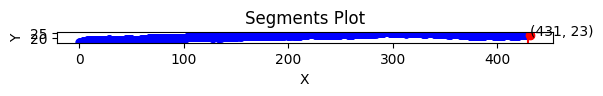

[{'segments': [{'length': 0.5601842999458313, 'angleToNextVector': 21.638526916503906, 'x': 0.5207074069599202, 'y': 16.206567776390408}, {'length': 0.5178755521774292, 'angleToNextVector': 0.7929458618164062, 'x': 1.0385333650056414, 'y': 16.213734694633843}, {'length': 0.41818779706954956, 'angleToNextVector': 1.2948989868164062, 'x': 1.456614367450986, 'y': 16.22318503918727}, {'length': 0.5792822241783142, 'angleToNextVector': 17.105789184570312, 'x': 2.010271057655723, 'y': 16.39357331531128}, {'length': 0.43702054023742676, 'angleToNextVector': 15.020828247070312, 'x': 2.4323593385600804, 'y': 16.50683599986633}, {'length': 0.46927139163017273, 'angleToNextVector': 18.851211547851562, 'x': 2.8764594058402695, 'y': 16.658463072792802}, {'length': 0.45881032943725586, 'angleToNextVector': 18.77204132080078, 'x': 3.310863963843935, 'y': 16.80610994334536}, {'length': 0.5852940678596497, 'angleToNextVector': 14.395591735839844, 'x': 3.8777811395512995, 'y': 16.951623041586313}, {'len

In [22]:

#new_discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1, hidden_size_discriminator2, hidden_size_discriminator3, hidden_size_discriminator4, output_size_discriminator).to(device)
#new_generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, hidden_size_generator6, hidden_size_generator7, output_size_generator).to(device)


new_discriminator = FNNDiscriminator(input_size_discriminator, 1, hidden_sizes_discriminator, output_size_discriminator).to(device)
new_generator = FNNGenerator(input_size_generator, 1, hidden_sizes_generator, output_size_generator).to(device)

new_discriminator.load_state_dict(torch.load('./testsaves/best_discriminator_test_1.pth'))
new_generator.load_state_dict(torch.load('./testsaves/best_generator_test_1.pth'))

# Generate new data after training
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
new_discriminator.eval()
new_generator.eval()
#min_val = torch.tensor([0.2211]).to(device)
#max_val = torch.tensor([0.6012]).to(device)
min_val = torch.tensor([0.0]).to(device) 
max_val = torch.tensor([1.0]).to(device) 
def normalize_condition(condition, min_val, max_val):
    return (condition - min_val) / (max_val - min_val)
# Generate new data after training
with torch.no_grad():  # Disable gradient computation for inference
    z = torch.randn(1, input_size_generator).to(device)  # Generate random noise
    specific_condition_value = 256
    dummy_condition = torch.tensor([[specific_condition_value]]).to(device)  # Fill tensor with specific value
    # Normalize the condition value
    normalized_condition = normalize_condition(specific_condition_value, min_val, max_val)
    dummy_condition = normalized_condition  # Use the normalized condition value
    fake_data = new_generator(z, dummy_condition)  # Pass both noise and condition
    fake_data = fake_data.view(fake_data.size(0), 855, 2)

fake_data[:, :, 1] = denormalize_angles(fake_data[:, :, 1])
generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})
    
print(generated_data)
# Example usage:
plot_segments_from_json(generated_data)
print(generated_data)

sample {'segments': [{'x': 0, 'y': 18.008305380247133, 'length': 0.5056049202125854, 'angleToNextVector': -8.539230171520959}, {'x': 0.5, 'y': 17.933229849325436, 'length': 0.5056049202125849, 'angleToNextVector': -8.539230171520563}, {'x': 1, 'y': 17.85815431840374, 'length': 0.5056049202125854, 'angleToNextVector': -8.539230171520959}, {'x': 1.5, 'y': 17.783078787482044, 'length': 0.5056049202125854, 'angleToNextVector': -8.539230171520959}, {'x': 2, 'y': 17.708003256560346, 'length': 0.5056049202125854, 'angleToNextVector': -8.539230171520959}, {'x': 2.5, 'y': 17.63292772563865, 'length': 0.5056049202125854, 'angleToNextVector': -8.539230171520959}, {'x': 3, 'y': 17.55785219471695, 'length': 0.5056049202125849, 'angleToNextVector': -8.539230171520563}, {'x': 3.5, 'y': 17.482776663795256, 'length': 0.5056049202125849, 'angleToNextVector': -8.539230171520563}, {'x': 4, 'y': 17.407701132873562, 'length': 0.5056049202125859, 'angleToNextVector': -8.539230171521357}, {'x': 4.5, 'y': 17.3

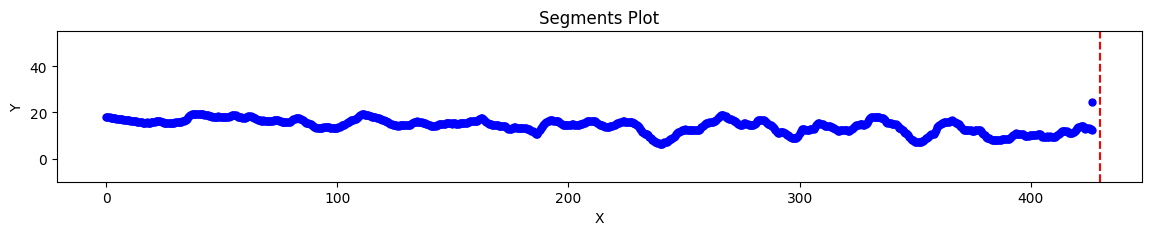

In [36]:
# open ground-1.json and plot the segment
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_segments_from_json(data):
    fig, ax = plt.subplots(figsize=(7, 4))
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        
        for segment in segments:
            x, y = segment["x"], segment["y"]
            
            # Plot the points and lines
            ax.plot(x, y, 'bo-', markersize=5)  # 'bo-' for blue line with circle markers
                
            
            

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    # draw horziontal line on the last y
    ax.axvline(x=430, color='r', linestyle='--')
    #set y limit from 15 to 55
    ax.set_ylim([-10,55])
    plt.savefig("../graphs/generated_data.png", dpi=900, bbox_inches='tight', pad_inches=0.1)
    # plt.show()



# with open('../learning-data/ground-6.json', 'r') as f:
#     temp_ground_data = json.load(f)
#     temp_segments = temp_ground_data['segments']
#     plot_segments_from_json([{"segments": temp_segments}])

with open('../validation-data/rand-ground-4.json', 'r') as f:
    temp_ground_data = json.load(f)
    temp_segments = temp_ground_data['segments']
    plot_segments_from_json([{"segments": temp_segments}])